# Python-Blosc2 user-defined codecs and filters

Python-Blosc2 now has support for user-defined codecs and filters as Python functions. These will work as normal codecs or filters respectively following the order depicted bellow:


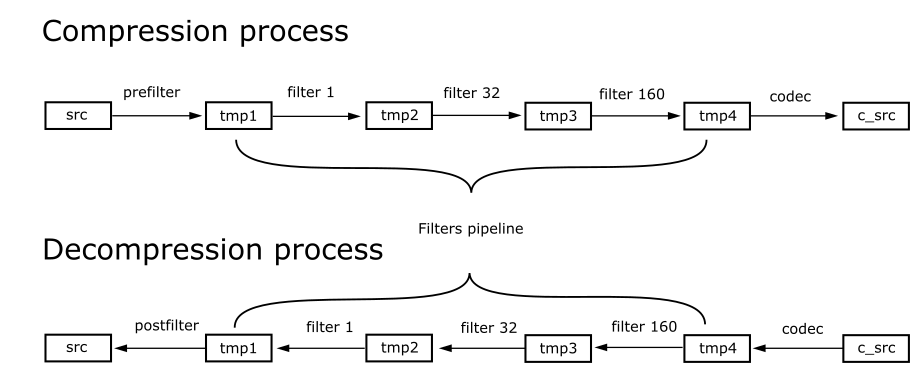



So when compressing, the first step will be to apply the prefilter (if any), then the filter pipeline with a maximum of six filters and, last but not least, the codec. For decompressing, the order will be the other way around: first the codec, then the filter pipeline and finally the postfilter (if any).

In this tutorial we will see how to create and use codecs and filters defined by yourself, so let's start by creating our schunk!

## User-defined codecs

Because a user-defined codec has Python code, we will not be able to use parallelism, so `nthreads` has to be 1 when compressing and decompressing:

In [1]:
import blosc2
import numpy as np
import sys

dtype = np.dtype(np.int32)
cparams = {
    "nthreads": 1,
    "typesize": dtype.itemsize,
}
dparams = {"nthreads": 1}

chunk_len = 10_000
schunk = blosc2.SChunk(chunksize=chunk_len * dtype.itemsize, cparams=cparams)

### Creating a codec

To create a codec we need two functions: one for compressing (aka *coder*) and another for decompressing (aka *decoder*). Let's begin first with the *coder* function:

In [2]:
def coder(input, output, meta, schunk):
    # Check whether the data is an arange
    nd_input = input.view(dtype)
    step = int(nd_input[1] - nd_input[0])
    res = nd_input[1:] - nd_input[:-1]
    if np.min(res) == np.max(res):
        output[0:4] = input[0:4]  # start
        n = step.to_bytes(4, sys.byteorder)
        output[4:8] = [n[i] for i in range(4)]
        return 8
    else:
        # Not compressible, tell Blosc2 to do a memcpy
        return 0

This function will receive the data input to compress as a ndarray of type uint8, the output to fill in the compressed buffer as a ndarray of type uint8 as well, the codec meta and the `SChunk` instance corresponding to the block that is being compressed. Furthermore, *coder* must return the size of the compressed buffer in bytes. If it cannot compress the data, it must return 0 and Blosc2 will copy it.

Now let's go for the *decoder*. Similarly to the previous function, it will receive the compressed input as a ndarray of type uint8, an output ndarray of type uint8 to fill it with the decompressed data, the codec meta and the corresponding `SChunk` instance as well.


In [3]:
def decoder(input, output, meta, schunk):
    nd_input = input.view(dtype)
    nd_output = output.view(dtype)
    nd_output[:] = [nd_input[0] + i * nd_input[1] for i in range(nd_output.size)]

    return nd_output.size * schunk.typesize

As it is for decompressing, this function will return the size of the decompressed buffer in bytes. If a block was memcopied by Blosc2, Blosc2 will take care of it without applying the *decoder*.

### Registering a codec

Now that we have everything needed, we can register our codec! For that, we will choose an identifier between 160 and 255.

In [4]:
codec_name = "our_codec"
codec_id = 160
blosc2.register_codec(codec_name, codec_id, coder, decoder)

### Using a codec

For actually using it, we will change our codec in the compression params using its id and remove the filters so that the codec receives the original data with no changes:

In [5]:
schunk.cparams = {
    "codec": codec_id,
    "codec_meta": 0,
    "filters": [blosc2.Filter.NOFILTER, blosc2.Filter.NOFILTER, blosc2.Filter.NOFILTER, blosc2.Filter.NOFILTER, blosc2.Filter.NOFILTER, blosc2.Filter.NOFILTER],
    "filters_meta": [0, 0, 0, 0, 0, 0]
}
schunk.cparams

{'codec': 160,
 'codec_meta': 0,
 'clevel': 5,
 'use_dict': 0,
 'typesize': 4,
 'nthreads': 1,
 'blocksize': 0,
 'splitmode': <SplitMode.FORWARD_COMPAT_SPLIT: 3>,
 'filters': [<Filter.NOFILTER: 0>,
  <Filter.NOFILTER: 0>,
  <Filter.NOFILTER: 0>,
  <Filter.NOFILTER: 0>,
  <Filter.NOFILTER: 0>,
  <Filter.NOFILTER: 0>],
 'filters_meta': [0, 0, 0, 0, 0, 0]}

Now we can check that our codec works well by apending and recovering some data:

In [6]:
nchunks = 3
data = np.arange(0, chunk_len * 3, dtype=dtype)
schunk[0:data.size] = data
print("schunk cratio: ", round(schunk.cratio, 2))

out = np.empty(data.shape, dtype=dtype)
schunk.get_slice(out=out)

np.array_equal(data, out)

schunk cratio:  833.33


True

Awesome, it works! Next, we will see the filters.

## User-defined filters

Once you get to do some codecs, filters are not different despite their goal is not to compress but to manipulate the data to make it easier to compress.

### Creating a filter

As for the codecs, to create a user-defined filter we will first need to create two functions: one for the compression process (aka *forward*) and another one for the decompression process (aka *backward*).

Let's write first the *forward* function:

In [7]:
def forward(input, output, meta, schunk):
    nd_input = input.view(dtype)
    nd_output = output.view(dtype)

    start = nd_input[0]
    nd_output[0] = start
    nd_output[1:] = nd_input[1:] - nd_input[:-1]

As you can see, the *forward* signature is exactly the same as the *coder* signature, the only difference is that the meta is the filter's meta. Regarding the return value though, the *forward* and *backward* functions do not have to return anything.

For *backward* it happens something similar:

In [8]:
def backward(input, output, meta, schunk):
    nd_input = input.view(dtype)
    nd_output = output.view(dtype)

    nd_output[0] = nd_input[0]
    for i in range(1, nd_output.size):
        nd_output[i] =  nd_output[i - 1] + nd_input[i]

A proper *backward* function has to undo the changes done by the associated *forward* function.

### Registering a filter

Once we have the two required functions, we can register our filter. In the same way we did for the codecs, we have to choose an identifier between 160 and 255:

In [9]:
filter_id = 160
blosc2.register_filter(filter_id, forward, backward)

### Using a filter in a SChunk

To use the filter we will set it in the filter pipeline using its id, and to actually compress something we will change the codec to a Blosc2 registered one:

In [10]:
schunk.cparams = {"filters": [filter_id], "filters_meta": [0], "codec": blosc2.Codec.BLOSCLZ}
schunk.cparams

{'codec': <Codec.BLOSCLZ: 0>,
 'codec_meta': 0,
 'clevel': 5,
 'use_dict': 0,
 'typesize': 4,
 'nthreads': 1,
 'blocksize': 0,
 'splitmode': <SplitMode.FORWARD_COMPAT_SPLIT: 3>,
 'filters': [160,
  <Filter.NOFILTER: 0>,
  <Filter.NOFILTER: 0>,
  <Filter.NOFILTER: 0>,
  <Filter.NOFILTER: 0>,
  <Filter.NOFILTER: 0>],
 'filters_meta': [0, 0, 0, 0, 0, 0]}

We will check that it actually works by updating the data:


In [11]:
new_data = np.arange(chunk_len, chunk_len * (nchunks + 1), dtype=dtype)

schunk[:] = new_data
print("schunk cratio: ", round(schunk.cratio, 2))

out = np.empty(new_data.shape, dtype=dtype)
schunk.get_slice(out=out)
np.array_equal(new_data, out)

schunk cratio:  189.57


True

Knowing that our data is equally spaced, we may want to take advantage of our filter with an specific codec. For that, we will create another codec:

In [12]:
def coder2(input, output, meta, schunk):
    nd_input = input.view(dtype)
    if np.min(nd_input[1:]) == np.max(nd_input[1:]):
        output[0:4] = input[0:4]  # start
        step = int(nd_input[1])
        n = step.to_bytes(4, sys.byteorder)
        output[4:8] = [n[i] for i in range(4)]
        return 8
    else:
        # Not compressible, tell Blosc2 to do a memcpy
        return 0

def decoder2(input, output, meta, schunk):
    nd_input = input.view(dtype)
    nd_output = output.view(dtype)
    nd_output[0] = nd_input[0]
    nd_output[1:] = nd_input[1]

    return nd_output.size * schunk.typesize

As the previous id is already in use, we will register it with another identifier:

In [13]:
codec_name2 = "our_codec2"
codec_id2 = 184
blosc2.register_codec(codec_name2, codec_id2, coder2, decoder2)

As done previously, we set it first to the `SChunk` instance:

In [14]:
schunk.cparams = {
    "codec": codec_id2,
    "codec_meta": 0,
}

And then update some data to see its performance:

In [15]:
new_data = np.arange(-chunk_len, chunk_len * (nchunks - 1), dtype=dtype)

schunk[:] = new_data
print("schunk cratio: ", round(schunk.cratio, 2))

out = np.empty(new_data.shape, dtype=dtype)
schunk.get_slice(out=out)
np.array_equal(new_data, out)

schunk cratio:  833.33


True

As can be seen, we obtained the same cratio as with the previous codec, so maybe it is not worth it to apply our filter for this particular case.

So now you know how to register a codec or filter and use it in your `SChunk`!
